In [3]:
import pandas as pd
import numpy as np
import json
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import RobertaModel, RobertaTokenizer

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Hyperparameters
MAX_VOCAB_SIZE = 10000
MAX_SEQ_LENGTH = 100
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
ROBERTA_DIM = 768 
FUSION_DIM = 128
BATCH_SIZE = 16   
LEARNING_RATE = 0.0005
NUM_EPOCHS = 10
DROPOUT_RATE = 0.5
FOCAL_LOSS_GAMMA = 2.0  
MAX_ROBERTA_LENGTH = 128  

In [4]:
# File paths
TRAIN_PATH = '/kaggle/input/diplomacy-dataset/train.jsonl'
VALIDATION_PATH = '/kaggle/input/diplomacy-dataset/validation.jsonl'
TEST_PATH = '/kaggle/input/diplomacy-dataset/test.jsonl'

In [ ]:
POWERS = ['austria', 'england', 'france', 'germany', 'italy', 'russia', 'turkey']

In [6]:
# Loading and preprocessing data

def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            game_data = json.loads(line.strip())

            for i in range(len(game_data['messages'])):
                if game_data['sender_labels'][i] == "NOANNOTATION":
                    continue

                entry = {
                    'message': game_data['messages'][i],
                    'speaker': game_data['speakers'][i],
                    'receiver': game_data['receivers'][i],
                    'score_delta': float(game_data['game_score_delta'][i]) if 'game_score_delta' in game_data else 0,
                    'abs_msg_idx': game_data['absolute_message_index'][i],
                    'rel_msg_idx': game_data['relative_message_index'][i],
                    'year': int(game_data['years'][i]) if 'years' in game_data else 1900,
                    'season': game_data['seasons'][i] if 'seasons' in game_data else "Unknown",
                    'message_length': len(game_data['messages'][i]),
                    'game_id': game_data.get('game_id', 0),
                    'is_deceptive': 1 if game_data['sender_labels'][i] == False else 0  # deceptive=1, truthful=0
                }
                data.append(entry)

    return pd.DataFrame(data)

print("Loading datasets...")
train_df = load_data(TRAIN_PATH)
val_df = load_data(VALIDATION_PATH)
test_df = load_data(TEST_PATH)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Loading datasets...
Train size: 13132, Validation size: 1416, Test size: 2741


In [5]:
#class distribution
print("Class distribution in training data:")
class_dist = train_df['is_deceptive'].value_counts(normalize=True)
print(class_dist)

Class distribution in training data:
is_deceptive
0    0.954995
1    0.045005
Name: proportion, dtype: float64


In [7]:
# Text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['processed_message'] = train_df['message'].apply(preprocess_text)
val_df['processed_message'] = val_df['message'].apply(preprocess_text)
test_df['processed_message'] = test_df['message'].apply(preprocess_text)

In [ ]:
# Apply season one hot encoding
def encode_season(season):
    seasons = ['Spring', 'Summer', 'Fall', 'Winter']
    encoding = [0] * len(seasons)
    try:
        idx = seasons.index(season)
        encoding[idx] = 1
    except ValueError:
        pass
    return encoding

train_df['season_encoded'] = train_df['season'].apply(encode_season)
val_df['season_encoded'] = val_df['season'].apply(encode_season)
test_df['season_encoded'] = test_df['season'].apply(encode_season)

In [ ]:
# Normalizing year
def normalize_year(year):
    return (year - 1900) / 10

train_df['year_normalized'] = train_df['year'].apply(normalize_year)
val_df['year_normalized'] = val_df['year'].apply(normalize_year)
test_df['year_normalized'] = test_df['year'].apply(normalize_year)

In [ ]:
# Normalizing message length
def normalize_length(length):
    return min(length / 100, 5)

train_df['length_normalized'] = train_df['message_length'].apply(normalize_length)
val_df['length_normalized'] = val_df['message_length'].apply(normalize_length)
test_df['length_normalized'] = test_df['message_length'].apply(normalize_length)

In [ ]:
# Power encoding - one-hot encoding for speaker and receiver
def encode_power(power):
    encoding = [0] * len(POWERS)
    try:
        idx = POWERS.index(power.lower())
        encoding[idx] = 1
    except ValueError:
        pass
    return encoding

train_df['speaker_encoded'] = train_df['speaker'].apply(encode_power)
val_df['speaker_encoded'] = val_df['speaker'].apply(encode_power)
test_df['speaker_encoded'] = test_df['speaker'].apply(encode_power)

train_df['receiver_encoded'] = train_df['receiver'].apply(encode_power)
val_df['receiver_encoded'] = val_df['receiver'].apply(encode_power)
test_df['receiver_encoded'] = test_df['receiver'].apply(encode_power)

In [ ]:
# Building vocabulary for BiLSTM
def build_vocab(texts, max_size):
    word_counts = Counter()
    for text in texts:
        words = text.split()
        word_counts.update(words)

    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in word_counts.most_common(max_size - len(vocab)):
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

print("Building vocabulary...")
vocab = build_vocab(train_df['processed_message'], MAX_VOCAB_SIZE)
print(f"Vocabulary size: {len(vocab)}")

In [ ]:
def tokenize(text, vocab, max_length):
    words = text.split()
    tokens = [vocab.get(word, vocab['<UNK>']) for word in words[:max_length]]

    if len(tokens) < max_length:
        tokens = tokens + [vocab['<PAD>']] * (max_length - len(tokens))

    return tokens

In [8]:
# Load RoBERTa tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [ ]:
class DiplomacyDataset(Dataset):
    def __init__(self, dataframe, vocab, max_length, roberta_tokenizer, max_roberta_length):
        self.messages = [tokenize(text, vocab, max_length) for text in dataframe['processed_message']]
        self.original_messages = dataframe['message'].values
        self.score_deltas = dataframe['score_delta'].values
        self.rel_msg_indices = dataframe['rel_msg_idx'].values / 10.0  # Normalize
        self.abs_msg_indices = dataframe['abs_msg_idx'].values / 1000.0  # Normalize
        self.years = dataframe['year_normalized'].values
        self.seasons = np.stack(dataframe['season_encoded'].values)
        self.message_lengths = dataframe['length_normalized'].values
        self.speaker_powers = np.stack(dataframe['speaker_encoded'].values)
        self.receiver_powers = np.stack(dataframe['receiver_encoded'].values)
        self.labels = dataframe['is_deceptive'].values
        self.roberta_tokenizer = roberta_tokenizer
        self.max_roberta_length = max_roberta_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        roberta_inputs = self.roberta_tokenizer(
            self.original_messages[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_roberta_length,
            return_tensors='pt'
        )
        
        return {
            'message': torch.tensor(self.messages[idx], dtype=torch.long),
            'roberta_input_ids': roberta_inputs['input_ids'].squeeze(0),
            'roberta_attention_mask': roberta_inputs['attention_mask'].squeeze(0),
            'score_delta': torch.tensor(self.score_deltas[idx], dtype=torch.float),
            'rel_msg_idx': torch.tensor(self.rel_msg_indices[idx], dtype=torch.float),
            'abs_msg_idx': torch.tensor(self.abs_msg_indices[idx], dtype=torch.float),
            'year': torch.tensor(self.years[idx], dtype=torch.float),
            'season': torch.tensor(self.seasons[idx], dtype=torch.float),
            'msg_length': torch.tensor(self.message_lengths[idx], dtype=torch.float),
            'speaker_power': torch.tensor(self.speaker_powers[idx], dtype=torch.float),
            'receiver_power': torch.tensor(self.receiver_powers[idx], dtype=torch.float),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
print("Creating datasets...")
train_dataset = DiplomacyDataset(train_df, vocab, MAX_SEQ_LENGTH, roberta_tokenizer, MAX_ROBERTA_LENGTH)
val_dataset = DiplomacyDataset(val_df, vocab, MAX_SEQ_LENGTH, roberta_tokenizer, MAX_ROBERTA_LENGTH)
test_dataset = DiplomacyDataset(test_df, vocab, MAX_SEQ_LENGTH, roberta_tokenizer, MAX_ROBERTA_LENGTH)

class_counts = np.bincount(train_df['is_deceptive'])
class_weights = 1.0 / class_counts
sample_weights = [class_weights[label] for label in train_df['is_deceptive']]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_df), replacement=True)

In [ ]:
#data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Focal Loss implementation
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha 
        self.size_average = size_average
        if alpha is not None:
            self.criterion = nn.CrossEntropyLoss(weight=alpha, reduction='none')
        else:
            self.criterion = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.criterion(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.size_average:
            return focal_loss.mean()
        else:
            return focal_loss.sum()

In [ ]:
# Combined BiLSTM + RoBERTa Model with attention
class DeceptionHybridModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, fusion_dim, roberta_dim, dropout_rate, num_layers=2):
        super(DeceptionHybridModel, self).__init__()

       
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                           batch_first=True, bidirectional=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        
       
        self.roberta = RobertaModel.from_pretrained('roberta-base')
       
        for param in self.roberta.parameters():
            param.requires_grad = False
            
       
        for param in self.roberta.encoder.layer[-1].parameters():
            param.requires_grad = True
            
       
        self.power_feature_layer = nn.Linear(14, hidden_dim) 
        self.feature_layer = nn.Linear(9, hidden_dim) 
        
        self.dropout = nn.Dropout(dropout_rate)
        self.fusion_layer = nn.Linear(hidden_dim * 2 + roberta_dim + hidden_dim * 2, fusion_dim)
        self.fc1 = nn.Linear(fusion_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)

    def attention_net(self, lstm_output):
        attn_weights = torch.tanh(self.attention(lstm_output))
        soft_attn_weights = torch.softmax(attn_weights, dim=1)
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights)
        return context.squeeze(2)

    def forward(self, message, roberta_input_ids, roberta_attention_mask, 
                score_delta, rel_msg_idx, abs_msg_idx, year, season, msg_length,
                speaker_power, receiver_power):
       
        embedded = self.embedding(message)
        lstm_out, _ = self.lstm(embedded)
        bilstm_attn_out = self.attention_net(lstm_out)
        bilstm_attn_out = self.dropout(bilstm_attn_out)
        

        with torch.no_grad():
            roberta_outputs = self.roberta(
                input_ids=roberta_input_ids,
                attention_mask=roberta_attention_mask,
                return_dict=True
            )
        roberta_out = roberta_outputs.last_hidden_state[:, 0, :] 
        
        features = torch.cat([
            score_delta.unsqueeze(1),
            rel_msg_idx.unsqueeze(1),
            abs_msg_idx.unsqueeze(1),
            year.unsqueeze(1),
            season,  
            msg_length.unsqueeze(1)
        ], dim=1)
        feature_out = torch.relu(self.feature_layer(features))
        
       
        power_features = torch.cat([speaker_power, receiver_power], dim=1)
        power_out = torch.relu(self.power_feature_layer(power_features))
       
        combined = torch.cat([bilstm_attn_out, roberta_out, feature_out, power_out], dim=1)
        fusion = torch.relu(self.fusion_layer(combined))
        fusion = self.dropout(fusion)
        
        hidden = torch.relu(self.fc1(fusion))
        hidden = self.dropout(hidden)
        output = self.fc2(hidden)

        return output

In [ ]:
# Initializing model
model = DeceptionHybridModel(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    fusion_dim=FUSION_DIM,
    roberta_dim=ROBERTA_DIM,
    dropout_rate=DROPOUT_RATE,
    num_layers=2
)

In [ ]:
# Calculate class weights for loss function
class_counts = np.bincount(train_df['is_deceptive'])
class_weights = torch.FloatTensor([1.0 / class_counts[0], 1.0 / class_counts[1]])
class_weights = class_weights / class_weights.sum()  
class_weights = class_weights * 2  

In [ ]:
# loss function
criterion = FocalLoss(gamma=FOCAL_LOSS_GAMMA, alpha=class_weights)

In [ ]:
# L2 regularization
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [ ]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

In [ ]:
# Training function
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(data_loader, desc="Training"):
        messages = batch['message'].to(device)
        roberta_input_ids = batch['roberta_input_ids'].to(device)
        roberta_attention_mask = batch['roberta_attention_mask'].to(device)
        score_deltas = batch['score_delta'].to(device)
        rel_msg_indices = batch['rel_msg_idx'].to(device)
        abs_msg_indices = batch['abs_msg_idx'].to(device)
        years = batch['year'].to(device)
        seasons = batch['season'].to(device)
        msg_lengths = batch['msg_length'].to(device)
        speaker_powers = batch['speaker_power'].to(device)
        receiver_powers = batch['receiver_power'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(messages, roberta_input_ids, roberta_attention_mask, 
                       score_deltas, rel_msg_indices, abs_msg_indices, years, 
                       seasons, msg_lengths, speaker_powers, receiver_powers)
        
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    return total_loss / len(data_loader), accuracy, f1

In [ ]:
# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []  

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            # Get data
            messages = batch['message'].to(device)
            roberta_input_ids = batch['roberta_input_ids'].to(device)
            roberta_attention_mask = batch['roberta_attention_mask'].to(device)
            score_deltas = batch['score_delta'].to(device)
            rel_msg_indices = batch['rel_msg_idx'].to(device)
            abs_msg_indices = batch['abs_msg_idx'].to(device)
            years = batch['year'].to(device)
            seasons = batch['season'].to(device)
            msg_lengths = batch['msg_length'].to(device)
            speaker_powers = batch['speaker_power'].to(device)
            receiver_powers = batch['receiver_power'].to(device)
            labels = batch['label'].to(device)

            outputs = model(messages, roberta_input_ids, roberta_attention_mask, 
                          score_deltas, rel_msg_indices, abs_msg_indices, years, 
                          seasons, msg_lengths, speaker_powers, receiver_powers)
            
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy())  

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    f1 = f1_score(all_labels, all_preds, average='macro')

    return total_loss / len(data_loader), accuracy, f1, all_preds, all_probs, all_labels

In [ ]:
# Finding optimal threshold
def find_optimal_threshold(y_true, y_probs):
    best_f1 = 0
    best_threshold = 0.5

    for threshold in np.arange(0.1, 0.9, 0.05):
        y_pred = (np.array(y_probs) >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred, average='macro')

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

In [ ]:
# confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')

In [ ]:
# Training
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, device):
    best_val_f1 = 0.0
    history = {'train_loss': [], 'train_acc': [], 'train_f1': [],
               'val_loss': [], 'val_acc': [], 'val_f1': []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, criterion, device)

        # Validate
        val_loss, val_acc, val_f1, _, val_probs, val_labels = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_f1)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        # Finding optimal threshold
        threshold, _ = find_optimal_threshold(val_labels, val_probs)
        print(f"Optimal threshold: {threshold:.2f}")

        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'threshold': threshold,
                'epoch': epoch
            }, '/kaggle/working/best_model.pt')
            print("Saved best model!")

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_f1'], label='Train F1')
    plt.plot(history['val_f1'], label='Val F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')

    return model, threshold
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
print("Starting training...")
model, threshold = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    device=device
)


In [9]:
# Load best model
checkpoint = torch.load('/kaggle/working/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
threshold = checkpoint['threshold']
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with threshold {threshold:.2f}")

/tmp/ipykernel_31/1522535639.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/best_model.pt')


Loaded best model from epoch 10 with threshold 0.85


In [ ]:
# Evaluation on test set
print("Evaluating on test set...")
test_loss, test_acc, test_f1, test_preds, test_probs, test_labels = evaluate(model, test_loader, criterion, device)

test_preds_threshold = (np.array(test_probs) >= threshold).astype(int)
threshold_acc = accuracy_score(test_labels, test_preds_threshold)
threshold_f1 = f1_score(test_labels, test_preds_threshold, average='macro')

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}")
print(f"With optimal threshold: Test Acc: {threshold_acc:.4f}, Test F1: {threshold_f1:.4f}")

In [ ]:
print("\nClassification Report (with optimal threshold):")
print(classification_report(test_labels, test_preds_threshold))

In [ ]:
cm = confusion_matrix(test_labels, test_preds_threshold)
plot_confusion_matrix(cm, ['Truthful', 'Deceptive'])

In [ ]:
test_predictions = pd.DataFrame({
    'predicted_prob': test_probs,
    'predicted_label': test_preds_threshold,
    'true_label': test_labels
})
test_predictions.to_csv('test_predictions.csv', index=False)

print("Test predictions saved.")

In [ ]:
# Inference 
def inference_on_example(model, example_json, roberta_tokenizer, vocab, device, threshold):
    """Run inference on a single example from the test set"""
   
    data = json.loads(example_json)
    results = []
    
    for i in range(len(data['messages'])):
        message = data['messages'][i]
        speaker = data['speakers'][i]
        receiver = data['receivers'][i]
        year = int(data['years'][i]) if 'years' in data else 1900
        season = data['seasons'][i] if 'seasons' in data else "Unknown"
        
       
        processed_message = preprocess_text(message)
        message_tokens = tokenize(processed_message, vocab, MAX_SEQ_LENGTH)
        season_enc = encode_season(season)
        year_norm = normalize_year(year)
        msg_length_norm = normalize_length(len(message))
        speaker_enc = encode_power(speaker)
        receiver_enc = encode_power(receiver)
        
       
        roberta_inputs = roberta_tokenizer(
            message,
            padding='max_length',
            truncation=True,
            max_length=MAX_ROBERTA_LENGTH,
            return_tensors='pt'
        )
        
       
        message_tensor = torch.tensor([message_tokens], dtype=torch.long).to(device)
        roberta_input_ids = roberta_inputs['input_ids'].to(device)
        roberta_attention_mask = roberta_inputs['attention_mask'].to(device)
        score_delta = torch.tensor([0.0], dtype=torch.float).to(device)  # Placeholder
        rel_msg_idx = torch.tensor([data['relative_message_index'][i] / 10.0], dtype=torch.float).to(device)
        abs_msg_idx = torch.tensor([data['absolute_message_index'][i] / 1000.0], dtype=torch.float).to(device)
        year_tensor = torch.tensor([year_norm], dtype=torch.float).to(device)
        season_tensor = torch.tensor([season_enc], dtype=torch.float).to(device)
        msg_length_tensor = torch.tensor([msg_length_norm], dtype=torch.float).to(device)
        speaker_tensor = torch.tensor([speaker_enc], dtype=torch.float).to(device)
        receiver_tensor = torch.tensor([receiver_enc], dtype=torch.float).to(device)
        
       
        model.eval()
        with torch.no_grad():
            outputs = model(
                message_tensor, 
                roberta_input_ids, 
                roberta_attention_mask,
                score_delta, 
                rel_msg_idx, 
                abs_msg_idx, 
                year_tensor, 
                season_tensor, 
                msg_length_tensor,
                speaker_tensor,
                receiver_tensor
            )
            
            probs = torch.softmax(outputs, dim=1)
            prob = probs[0][1].item()  
            prediction = 1 if prob >= threshold else 0
            
        
        true_label = "N/A" 
        if 'sender_labels' in data and i < len(data['sender_labels']) and data['sender_labels'][i] != "NOANNOTATION":
            true_label = "Deceptive" if data['sender_labels'][i] == False else "Truthful"
            
        results.append({
            'message': message,
            'speaker': speaker,
            'receiver': receiver,
            'year': year,
            'season': season,
            'deception_probability': prob,
            'prediction': "Deceptive" if prediction == 1 else "Truthful",
            'true_label': true_label
        })
    
    return results

In [ ]:
# Example from test data
example_json = """
{"messages": ["Hi Italy! Just opening up communication, and I want to know what some of your initial thoughts on the game are and if/how we can work together", "Well....that's a great question, and a lot of it comes down to how free I'll be left to play in the West, no?", "Well, if you want to attack France in the Mediterranean while I attack through Burgundy you can have Marseille and Iberia while I take Brest and Paris, then with France out of the way you could focus on Turkey or Austria. Sound fair?", "Totally understandable - but did you notice the attempt at Trieste?  Tyrolia is the natural support position for that attempt 😂"], "sender_labels": [true, true, true, true], "receiver_labels": [true, true, false, true], "speakers": ["germany", "italy", "germany", "germany"], "receivers": ["italy", "germany", "italy", "italy"], "absolute_message_index": [87, 132, 138, 207], "relative_message_index": [0, 1, 2, 3], "seasons": ["Spring", "Spring", "Spring", "Winter"], "years": ["1901", "1901", "1901", "1901"], "game_score": ["3", "3", "3", "5"], "game_score_delta": ["0", "0", "0", "1"], "players": ["italy", "germany"], "game_id": 12}
"""

In [ ]:
def run_inference_examples(model_path, examples):
 
    model = DeceptionHybridModel(
        vocab_size=len(vocab),
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=HIDDEN_DIM,
        fusion_dim=FUSION_DIM,
        roberta_dim=ROBERTA_DIM,
        dropout_rate=DROPOUT_RATE,
        num_layers=2
    )
    
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    threshold = checkpoint['threshold']
    model = model.to(device)
    
    print(f"Running inference with model from epoch {checkpoint['epoch']+1} with threshold {threshold:.2f}")
    
    all_results = []
    for example in examples:
        results = inference_on_example(model, example, roberta_tokenizer, vocab, device, threshold)
        all_results.append(results)
        

        print("\n==== Example Inference Results ====")
        for i, res in enumerate(results):
            print(f"\nMessage {i+1}:")
            print(f"From: {res['speaker']} To: {res['receiver']}")
            print(f"Time: {res['season']} {res['year']}")
            print(f"Message: {res['message']}")
            print(f"Prediction: {res['prediction']} (probability: {res['deception_probability']:.4f})")
            if res['true_label'] != "N/A":
                print(f"True label: {res['true_label']}")
            print("-" * 50)
    
    return all_results


examples = [example_json]
inference_results = run_inference_examples('/kaggle/working/best_model.pt', examples)


with open('inference_results.json', 'w') as f:
    json.dump(inference_results, f, indent=2)

print("Inference results saved to 'inference_results.json'")

def analyze_feature_importance(model, example_json, roberta_tokenizer, vocab, device):
    """Analyze which features contribute most to deception prediction"""

    data = json.loads(example_json)
 
    idx = 2 
    
    message = data['messages'][idx]
    speaker = data['speakers'][idx]
    receiver = data['receivers'][idx]
    year = int(data['years'][idx]) if 'years' in data else 1900
    season = data['seasons'][idx] if 'seasons' in data else "Unknown"
    
    processed_message = preprocess_text(message)
    message_tokens = tokenize(processed_message, vocab, MAX_SEQ_LENGTH)
    season_enc = encode_season(season)
    year_norm = normalize_year(year)
    msg_length_norm = normalize_length(len(message))
    speaker_enc = encode_power(speaker)
    receiver_enc = encode_power(receiver)
    

    roberta_inputs = roberta_tokenizer(
        message,
        padding='max_length',
        truncation=True,
        max_length=MAX_ROBERTA_LENGTH,
        return_tensors='pt'
    )
    

    message_tensor = torch.tensor([message_tokens], dtype=torch.long).to(device)
    roberta_input_ids = roberta_inputs['input_ids'].to(device)
    roberta_attention_mask = roberta_inputs['attention_mask'].to(device)
    score_delta = torch.tensor([0.0], dtype=torch.float).to(device)
    rel_msg_idx = torch.tensor([data['relative_message_index'][idx] / 10.0], dtype=torch.float).to(device)
    abs_msg_idx = torch.tensor([data['absolute_message_index'][idx] / 1000.0], dtype=torch.float).to(device)
    year_tensor = torch.tensor([year_norm], dtype=torch.float).to(device)
    season_tensor = torch.tensor([season_enc], dtype=torch.float).to(device)
    msg_length_tensor = torch.tensor([msg_length_norm], dtype=torch.float).to(device)
    speaker_tensor = torch.tensor([speaker_enc], dtype=torch.float).to(device)
    receiver_tensor = torch.tensor([receiver_enc], dtype=torch.float).to(device)
    

    model.eval()
    with torch.no_grad():
        outputs = model(
            message_tensor, 
            roberta_input_ids, 
            roberta_attention_mask,
            score_delta, 
            rel_msg_idx, 
            abs_msg_idx, 
            year_tensor, 
            season_tensor, 
            msg_length_tensor,
            speaker_tensor,
            receiver_tensor
        )
        
        probs = torch.softmax(outputs, dim=1)
        original_prob = probs[0][1].item() 
    
  
    feature_importance = {}
    

    with torch.no_grad():
        perturbed_length = torch.tensor([0.1], dtype=torch.float).to(device)  # Much shorter message
        outputs = model(
            message_tensor, 
            roberta_input_ids, 
            roberta_attention_mask,
            score_delta, 
            rel_msg_idx, 
            abs_msg_idx, 
            year_tensor, 
            season_tensor, 
            perturbed_length,
            speaker_tensor,
            receiver_tensor
        )
        probs = torch.softmax(outputs, dim=1)
        perturbed_prob = probs[0][1].item()
        feature_importance['message_length'] = abs(original_prob - perturbed_prob)
    
    with torch.no_grad():
   
        different_speaker = encode_power("austria")  
        perturbed_speaker = torch.tensor([different_speaker], dtype=torch.float).to(device)
        outputs = model(
            message_tensor, 
            roberta_input_ids, 
            roberta_attention_mask,
            score_delta, 
            rel_msg_idx, 
            abs_msg_idx, 
            year_tensor, 
            season_tensor, 
            msg_length_tensor,
            perturbed_speaker,
            receiver_tensor
        )
        probs = torch.softmax(outputs, dim=1)
        perturbed_prob = probs[0][1].item()
        feature_importance['speaker_power'] = abs(original_prob - perturbed_prob)
    
    with torch.no_grad():
        different_receiver = encode_power("france")  
        perturbed_receiver = torch.tensor([different_receiver], dtype=torch.float).to(device)
        outputs = model(
            message_tensor, 
            roberta_input_ids, 
            roberta_attention_mask,
            score_delta, 
            rel_msg_idx, 
            abs_msg_idx, 
            year_tensor, 
            season_tensor, 
            msg_length_tensor,
            speaker_tensor,
            perturbed_receiver
        )
        probs = torch.softmax(outputs, dim=1)
        perturbed_prob = probs[0][1].item()
        feature_importance['receiver_power'] = abs(original_prob - perturbed_prob)

    with torch.no_grad():
        perturbed_year = torch.tensor([normalize_year(1905)], dtype=torch.float).to(device) 
        outputs = model(
            message_tensor, 
            roberta_input_ids, 
            roberta_attention_mask,
            score_delta, 
            rel_msg_idx, 
            abs_msg_idx, 
            perturbed_year, 
            season_tensor, 
            msg_length_tensor,
            speaker_tensor,
            receiver_tensor
        )
        probs = torch.softmax(outputs, dim=1)
        perturbed_prob = probs[0][1].item()
        feature_importance['year'] = abs(original_prob - perturbed_prob)
    
 
    with torch.no_grad():
        different_season = encode_season("Fall")  
        perturbed_season = torch.tensor([different_season], dtype=torch.float).to(device)
        outputs = model(
            message_tensor, 
            roberta_input_ids, 
            roberta_attention_mask,
            score_delta, 
            rel_msg_idx, 
            abs_msg_idx, 
            year_tensor, 
            perturbed_season, 
            msg_length_tensor,
            speaker_tensor,
            receiver_tensor
        )
        probs = torch.softmax(outputs, dim=1)
        perturbed_prob = probs[0][1].item()
        feature_importance['season'] = abs(original_prob - perturbed_prob)
    
 
    plt.figure(figsize=(10, 6))
    features = list(feature_importance.keys())
    importance = list(feature_importance.values())
    
    plt.bar(features, importance)
    plt.title(f'Feature Importance for Deception Detection\nOriginal Probability: {original_prob:.4f}')
    plt.xlabel('Features')
    plt.ylabel('Importance (Change in probability)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    
    return feature_importance


feature_importance = analyze_feature_importance(model, example_json, roberta_tokenizer, vocab, device)
print("Feature importance analysis:")
for feature, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

Loading datasets...
Train size: 13132, Validation size: 1416, Test size: 2741
Class distribution in training data:
is_deceptive
0    0.954995
1    0.045005
Name: proportion, dtype: float64
Building vocabulary...
Vocabulary size: 8633
Creating datasets...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Starting training...
Epoch 1/10


Evaluating: 100%|██████████| 89/89 [00:05<00:00, 16.21it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1360
           1       0.04      1.00      0.08        56

    accuracy                           0.04      1416
   macro avg       0.02      0.50      0.04      1416
weighted avg       0.00      0.04      0.00      1416


Confusion Matrix:
[[   0 1360]
 [   0   56]]
Train Loss: 0.0164, Train Acc: 0.5077, Train F1: 0.3393
Val Loss: 0.0095, Val Acc: 0.0395, Val F1: 0.0380
Optimal threshold: 0.10
Saved best model!
Epoch 2/10


Evaluating: 100%|██████████| 89/89 [00:05<00:00, 16.11it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1360
           1       0.04      1.00      0.08        56

    accuracy                           0.04      1416
   macro avg       0.02      0.50      0.04      1416
weighted avg       0.00      0.04      0.00      1416


Confusion Matrix:
[[   0 1360]
 [   0   56]]
Train Loss: 0.0082, Train Acc: 0.4980, Train F1: 0.3325
Val Loss: 0.0088, Val Acc: 0.0395, Val F1: 0.0380
Optimal threshold: 0.85
Epoch 3/10


Evaluating: 100%|██████████| 89/89 [00:05<00:00, 16.09it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1360
           1       0.04      1.00      0.08        56

    accuracy                           0.04      1416
   macro avg       0.02      0.50      0.04      1416
weighted avg       0.00      0.04      0.00      1416


Confusion Matrix:
[[   0 1360]
 [   0   56]]
Train Loss: 0.0073, Train Acc: 0.5065, Train F1: 0.3362
Val Loss: 0.0083, Val Acc: 0.0395, Val F1: 0.0380
Optimal threshold: 0.85
Epoch 4/10


Evaluating: 100%|██████████| 89/89 [00:05<00:00, 16.13it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1360
           1       0.04      1.00      0.08        56

    accuracy                           0.04      1416
   macro avg       0.02      0.50      0.04      1416
weighted avg       0.00      0.04      0.00      1416


Confusion Matrix:
[[   0 1360]
 [   0   56]]
Train Loss: 0.0064, Train Acc: 0.5005, Train F1: 0.3335
Val Loss: 0.0086, Val Acc: 0.0395, Val F1: 0.0380
Optimal threshold: 0.85
Epoch 5/10


Evaluating: 100%|██████████| 89/89 [00:05<00:00, 16.12it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1360
           1       0.04      1.00      0.08        56

    accuracy                           0.04      1416
   macro avg       0.02      0.50      0.04      1416
weighted avg       0.00      0.04      0.00      1416


Confusion Matrix:
[[   0 1360]
 [   0   56]]
Train Loss: 0.0051, Train Acc: 0.5008, Train F1: 0.3337
Val Loss: 0.0074, Val Acc: 0.0395, Val F1: 0.0380
Optimal threshold: 0.85
Epoch 6/10


Evaluating: 100%|██████████| 89/89 [00:05<00:00, 16.37it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1360
           1       0.04      1.00      0.08        56

    accuracy                           0.04      1416
   macro avg       0.02      0.50      0.04      1416
weighted avg       0.00      0.04      0.00      1416


Confusion Matrix:
[[   0 1360]
 [   0   56]]
Train Loss: 0.0046, Train Acc: 0.5053, Train F1: 0.3357
Val Loss: 0.0072, Val Acc: 0.0395, Val F1: 0.0380
Optimal threshold: 0.85
Epoch 7/10


Evaluating: 100%|██████████| 89/89 [00:05<00:00, 16.31it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1360
           1       0.04      1.00      0.08        56

    accuracy                           0.04      1416
   macro avg       0.02      0.50      0.04      1416
weighted avg       0.00      0.04      0.00      1416


Confusion Matrix:
[[   0 1360]
 [   0   56]]
Train Loss: 0.0041, Train Acc: 0.4941, Train F1: 0.3310
Val Loss: 0.0063, Val Acc: 0.0395, Val F1: 0.0380
Optimal threshold: 0.85
Epoch 8/10


Evaluating: 100%|██████████| 89/89 [00:05<00:00, 16.32it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1360
           1       0.04      1.00      0.08        56

    accuracy                           0.04      1416
   macro avg       0.02      0.50      0.04      1416
weighted avg       0.00      0.04      0.00      1416


Confusion Matrix:
[[   0 1360]
 [   0   56]]
Train Loss: 0.0034, Train Acc: 0.5189, Train F1: 0.3710
Val Loss: 0.0079, Val Acc: 0.0395, Val F1: 0.0380
Optimal threshold: 0.85
Epoch 9/10


Evaluating: 100%|██████████| 89/89 [00:05<00:00, 16.40it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.14      0.24      1360
           1       0.04      0.93      0.08        56

    accuracy                           0.17      1416
   macro avg       0.51      0.53      0.16      1416
weighted avg       0.94      0.17      0.23      1416


Confusion Matrix:
[[ 185 1175]
 [   4   52]]
Train Loss: 0.0032, Train Acc: 0.5506, Train F1: 0.4426
Val Loss: 0.0116, Val Acc: 0.1674, Val F1: 0.1600
Optimal threshold: 0.85
Saved best model!
Epoch 10/10


Evaluating: 100%|██████████| 89/89 [00:05<00:00, 16.40it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.17      0.29      1360
           1       0.04      0.93      0.08        56

    accuracy                           0.20      1416
   macro avg       0.51      0.55      0.19      1416
weighted avg       0.95      0.20      0.28      1416


Confusion Matrix:
[[ 231 1129]
 [   4   52]]
Train Loss: 0.0028, Train Acc: 0.6015, Train F1: 0.5196
Val Loss: 0.0119, Val Acc: 0.1999, Val F1: 0.1869
Optimal threshold: 0.85
Saved best model!


/tmp/ipykernel_31/1500034445.py:572: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/best_model.pt')


Loaded best model from epoch 10 with threshold 0.85
Evaluating on test set...


Evaluating: 100%|██████████| 172/172 [00:10<00:00, 16.21it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.19      0.31      2501
           1       0.09      0.88      0.17       240

    accuracy                           0.25      2741
   macro avg       0.52      0.53      0.24      2741
weighted avg       0.87      0.25      0.30      2741


Confusion Matrix:
[[ 469 2032]
 [  30  210]]
Test Loss: 0.0279, Test Acc: 0.2477, Test F1: 0.2409
With optimal threshold: Test Acc: 0.6859, Test F1: 0.4903

Classification Report (with optimal threshold):
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      2501
           1       0.11      0.38      0.17       240

    accuracy                           0.69      2741
   macro avg       0.52      0.55      0.49      2741
weighted avg       0.85      0.69      0.75      2741

Test predictions saved.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1500034445.py:709: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start 

Running inference with model from epoch 10 with threshold 0.85

==== Example Inference Results ====

Message 1:
From: germany To: italy
Time: Spring 1901
Message: Hi Italy! Just opening up communication, and I want to know what some of your initial thoughts on the game are and if/how we can work together
Prediction: Truthful (probability: 0.5740)
True label: Truthful
--------------------------------------------------

Message 2:
From: italy To: germany
Time: Spring 1901
Message: Well....that's a great question, and a lot of it comes down to how free I'll be left to play in the West, no?
Prediction: Truthful (probability: 0.7769)
True label: Truthful
--------------------------------------------------

Message 3:
From: germany To: italy
Time: Spring 1901
Message: Well, if you want to attack France in the Mediterranean while I attack through Burgundy you can have Marseille and Iberia while I take Brest and Paris, then with France out of the way you could focus on Turkey or Austria. Sound 

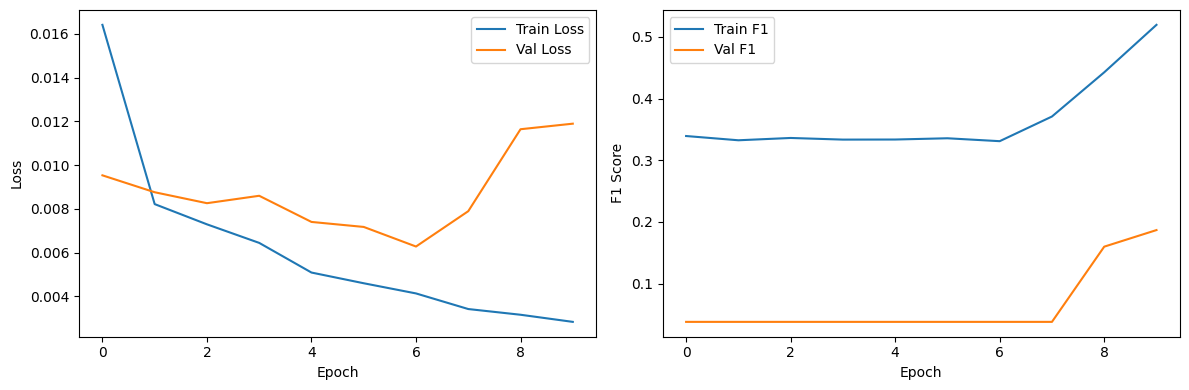

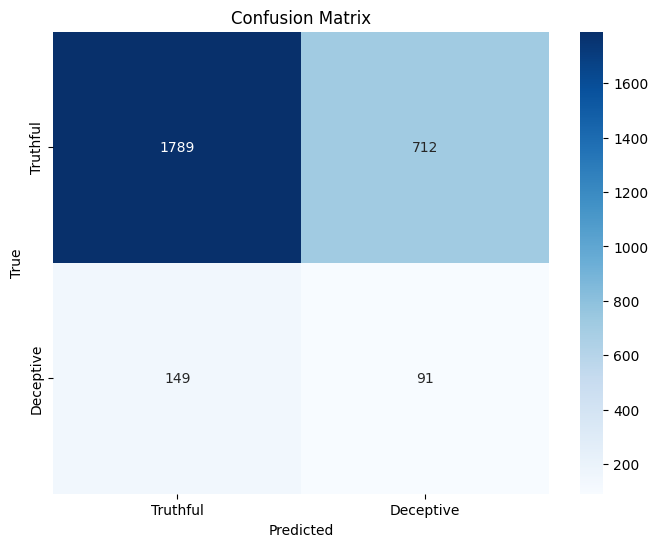

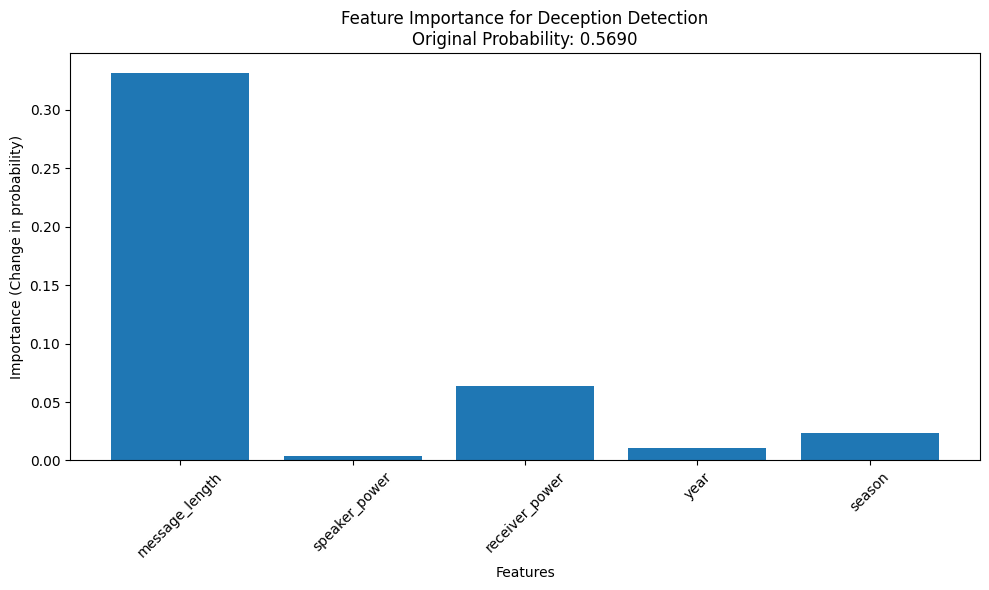

In [2]:

def predict_deception(model, text, speaker, receiver, year, season, roberta_tokenizer, vocab, device, threshold):
    """Make a deception prediction on a new message"""
  
    processed_message = preprocess_text(text)
    message_tokens = tokenize(processed_message, vocab, MAX_SEQ_LENGTH)
    season_enc = encode_season(season)
    year_norm = normalize_year(int(year))
    msg_length_norm = normalize_length(len(text))
    speaker_enc = encode_power(speaker.lower())
    receiver_enc = encode_power(receiver.lower())
    

    roberta_inputs = roberta_tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=MAX_ROBERTA_LENGTH,
        return_tensors='pt'
    )
    

    message_tensor = torch.tensor([message_tokens], dtype=torch.long).to(device)
    roberta_input_ids = roberta_inputs['input_ids'].to(device)
    roberta_attention_mask = roberta_inputs['attention_mask'].to(device)
    score_delta = torch.tensor([0.0], dtype=torch.float).to(device)  # Placeholder
    rel_msg_idx = torch.tensor([0.1], dtype=torch.float).to(device)  # Placeholder
    abs_msg_idx = torch.tensor([0.1], dtype=torch.float).to(device)  # Placeholder
    year_tensor = torch.tensor([year_norm], dtype=torch.float).to(device)
    season_tensor = torch.tensor([season_enc], dtype=torch.float).to(device)
    msg_length_tensor = torch.tensor([msg_length_norm], dtype=torch.float).to(device)
    speaker_tensor = torch.tensor([speaker_enc], dtype=torch.float).to(device)
    receiver_tensor = torch.tensor([receiver_enc], dtype=torch.float).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(
            message_tensor, 
            roberta_input_ids, 
            roberta_attention_mask,
            score_delta, 
            rel_msg_idx, 
            abs_msg_idx, 
            year_tensor, 
            season_tensor, 
            msg_length_tensor,
            speaker_tensor,
            receiver_tensor
        )
        
        probs = torch.softmax(outputs, dim=1)
        deception_prob = probs[0][1].item()
        prediction = "Deceptive" if deception_prob >= threshold else "Truthful"
        
    return {
        'message': text,
        'deception_probability': deception_prob,
        'prediction': prediction,
        'confidence': max(deception_prob, 1-deception_prob)
    }

custom_examples = [
    {
        'text': "Let's work together to attack France - I promise I won't move into your territory.",
        'speaker': 'germany',
        'receiver': 'england',
        'year': '1901',
        'season': 'Spring'
    },
    {
        'text': "I'm moving my troops to the border only as a defensive measure, not planning to attack you at all.",
        'speaker': 'russia',
        'receiver': 'austria',
        'year': '1902',
        'season': 'Fall'
    },
    {
        'text': "Thank you for your support last turn, I'll make sure to return the favor in the next round.",
        'speaker': 'italy',
        'receiver': 'france',
        'year': '1903',
        'season': 'Summer'
    }
]

print("\n==== Custom Example Predictions ====")
for example in custom_examples:
    result = predict_deception(
        model,
        example['text'],
        example['speaker'],
        example['receiver'],
        example['year'],
        example['season'],
        roberta_tokenizer,
        vocab,
        device,
        threshold
    )
    
    print(f"\nFrom: {example['speaker']} To: {example['receiver']}")
    print(f"Time: {example['season']} {example['year']}")
    print(f"Message: {example['text']}")
    print(f"Prediction: {result['prediction']} (probability: {result['deception_probability']:.4f})")
    print(f"Confidence: {result['confidence']:.4f}")
    print("-" * 50)

def model_summary_str(model):
    """Generate a string summary of the model"""
    model_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    summary = f"Model Summary:\n"
    summary += f"Total parameters: {model_params:,}\n"
    summary += f"Trainable parameters: {trainable_params:,}\n"
    summary += f"BiLSTM hidden dimension: {HIDDEN_DIM}\n"
    summary += f"RoBERTa embedding dimension: {ROBERTA_DIM}\n"
    summary += f"Fusion dimension: {FUSION_DIM}\n"
    summary += f"Dropout rate: {DROPOUT_RATE}\n"
    summary += f"Learning rate: {LEARNING_RATE}\n"
    
    return summary

print(model_summary_str(model))

with open('model_summary.txt', 'w') as f:
    f.write(model_summary_str(model))

print("Model summary saved to 'model_summary.txt'")

print("All tasks completed successfully!")